In [11]:
palette = ['#3B8EA1', '#B84D4A', '#6F5B9A', '#B59F8E', '#D96B9A', '#A3A3A3', '#D88F3B', '#4C9F4A']
from pathlib import Path
computational_data = Path("..") / "data" / "other_data" / "computational_data"
variant_scores = Path("..") / "data" / "processed_scores"
figure = Path("..") / "figures"
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf
from matplotlib.patches import Circle
from __future__ import print_function
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import logging
logger = logging.getLogger(__name__)
plot_cmaps = {"diverging": "RdBu_r", "sequential": "Blues_r", "hexbin": "YlGnBu_r"}

#: Default colors for Enrich2 plots.
#: Standard defaults are based on ColorBrewer Set1 and Pastel1.
plot_colors = {"bright1": "#377eb8", "bright2": "#4daf4a", "bright3": "#ff7f00", "bright4": "#984ea3", "bright5": "#e41a1c",
               "bright6": "#a65628", "pastel1": "#b3cde3", "pastel2": "#ccebc5", "pastel3": "#fed9a6", "pastel4": "#decbe4",
               "pastel5": "#fbb4ae", "pastel6": "#e5d8bd", "accent1": "#000000", "accent2": "#545454", "accent3": "#bebebe",
               "accent4": "#999999", "missing": "#939393"}
#: List of amino acids in row order for sequence-function maps.
AA_LIST = ["H", "K", "R", "D", "E", "C", "M", "N", "Q", "S", "T", "A", "I", "L", "V", "F", "W", "Y", "G", "P", "*"]
AA_LABEL_GROUPS = [("(+)", 0, 2),("(-)", 3, 4),("Polar-Neutral", 5, 10),("Non-polar", 11, 14),("Aromatic", 15, 17),("Unique", 18, 19)]
NT_LIST = ["A", "C", "G", "T"]

In [3]:
def parse_aa_list(fname):
    group_labels = list()
    groups = list()
    found_aa = list()
    with open(fname) as handle:
        for line in handle:
            if line.startswith("#"):
                continue
            if len(line) == 0:
                continue
            try:
                label, aa = line.split("\t")
            except ValueError:
                raise ValueError(
                    "Unexpected AA list file line format [{}]" "".format("SFMAP.PY"))
            aa = aa.split(",")
            aa = [x.strip() for x in aa]
            if any(x not in AA_LIST for x in aa):
                raise ValueError(
                    "Invalid amino acid in AA list file [{}]" "".format("SFMAP.PY"))
            else:
                group_labels.append(label)
                groups.append(aa)
                found_aa.extend(aa)
    if any(x not in found_aa for x in AA_LIST):
        raise ValueError("Not all amino acids assigned in AA list file [{}]" "".format("SFMAP.PY"))
    if len(AA_LIST) != len(found_aa):
        raise ValueError("Duplicate assignments in AA list file [{}]" "".format("SFMAP.PY"))
    pos = -1
    aa_label_groups = list()
    for i, label in enumerate(group_labels):
        aa_label_groups.append((label, pos + 1, pos + len(groups[i])))
        pos = pos + len(groups[i])
    return found_aa, aa_label_groups

In [4]:
def recentered_cmap(cmap, vmin, vmax):
    # regular index to compute the colors
    reg_index = np.linspace(0.0, 1.0, 257)

    # shifted index to match the data
    centerpoint = 1 - vmax / (vmax + abs(vmin))
    shift_index = np.hstack(
        [np.linspace(0.0, centerpoint, 128, endpoint=False),np.linspace(centerpoint, 1.0, 129, endpoint=True),])
    # re-map the colors at each index value using a dictionary
    cdict = {"red": [], "green": [], "blue": [], "alpha": []}
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict["red"].append((si, r, r))
        cdict["green"].append((si, g, g))
        cdict["blue"].append((si, b, b))
        cdict["alpha"].append((si, a, a))
    # save the dictionary as a color map
    newcmap = LinearSegmentedColormap("recentered", cdict)
    return newcmap

In [5]:
def sfmap_axes(
    df,ax,style,wt,sfmap_name=None,df_se=None,tall=False,colors=None,missing_color=None,vmin=None,vmax=None,
    vmax_se=None,show_positions=True,show_wt=True,show_variants=True,aa_list=AA_LIST,aa_label_groups=AA_LABEL_GROUPS,):
    if style not in ("counts", "logcounts", "scores"):
        logger.warning("Invalid style specified for sfmap_axes")
        return None

    # rotate if necessary
    if not tall:
        df = df.transpose()
        if df_se is not None:
            df_se = df_se.transpose()

    # re-order the rows for plotting
    df = df.reindex(index=df.index[::-1])
    if df_se is not None:
        df_se = df_se.reindex(index=df_se.index[::-1])

    # log transform counts if necessary
    if style == "logcounts":
        df = np.log10(df)

    # mask NaN so we can color them separately
    masked = np.ma.array(df, mask=np.isnan(df))
    if df_se is not None:
        masked_se = np.ma.array(df_se, mask=np.isnan(df_se))

    # set colors and min/max data values
    if style == "counts" or style == "logcounts":
        try:
            if colors is not None:
                cmap = plt.get_cmap(colors)
            else:
                cmap = plt.get_cmap(plot_cmaps["diverging"])
        except ValueError:
            logger.warning(
                "Invalid sequential color map choice. " "Falling back to 'BuPu'"
            )
            cmap = plt.get_cmap("BuPu")
        if vmin is None:
            vmin = 0.0
        if vmax is None:
            vmax = masked.max()
    else:  # style == "scores"
        try:
            if colors is not None:
                cmap = plt.get_cmap(colors)
            else:
                cmap = plt.get_cmap(plot_cmaps["diverging"])
        except ValueError:
            logger.warning(
                "Invalid diverging color map choice. " "Falling back to 'RdYlBu_r'"
            )
            cmap = plt.get_cmap("RdYlBu_r")
        if vmin is None:
            vmin = masked.min()
        if vmax is None:
            vmax = masked.max()
        if vmin < 0.0 and vmax > 0.0:
            cmap = recentered_cmap(cmap, vmin, vmax)
    if missing_color is not None:
        cmap.set_bad(missing_color, 1.0)
    else:
        cmap.set_bad(plot_colors["missing"], 1.0)

    # draw the heatmap and get rid of extra whitespace
    mesh = ax.pcolormesh(masked, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlim(0, len(df.columns))
    ax.set_ylim(0, len(df.index))

    # add marks on wild type positions
    wt = list(wt)
    if tall:
        wt_xy = zip((list(df.columns).index(x) for x in wt), reversed(range(len(wt))))
    else:
        wt_xy = zip(range(len(wt)), (list(df.index).index(x) for x in wt))
    for x, y in wt_xy:
        ax.add_patch(Circle((x + 0.5, y + 0.5),0.1666,fill=True,facecolor="black",edgecolor="none",alpha=0.5,))
    # add diagonal SE marks
    if df_se is not None:
        if vmax_se is None:
            vmax_se = masked_se.max()
        # rescale the SE's onto 0 .. 0.98
        # rescaling onto 0 .. 1.0 causes the corners to look funny
        masked_se = masked_se / vmax_se * 0.98
        for x in range(len(df.index)):
            for y in range(len(df.columns)):
                value = masked_se[x, y]
                if value and value >= 0.02:  # not masked, above threshold
                    corner_dist = (1.0 - value) / 2.0
                    diag = Line2D([y + corner_dist, y + 1 - corner_dist],[x + corner_dist, x + 1 - corner_dist],transform=ax.transData,
                                  color="grey",)
                    ax.add_line(diag)
    # calculate tick label positions
    ypos = np.arange(len(df.index)) + 0.5
    xpos = np.arange(len(df.columns)) + 0.5
    ax.set_yticks(ypos)
    ax.set_xticks(xpos)
    # create the secondary axis for the wild type sequence
    if tall:
        wt_ax = ax.twinx()
        wt_ax.set_yticks(ypos)
    else:
        wt_ax = ax.twiny()
        wt_ax.set_xticks(xpos)

    # add the integer position axis tick labels
    if show_positions:
        # add position axis label
        if tall:
            ax.set_ylabel("Amino Acid Position")
        else:
            ax.set_xlabel("Amino Acid Position", fontsize = 35)
            ax.set_ylabel("Amino Acid Change", fontsize = 35)
        if tall:
            ax.set_yticklabels([x+1 for x in list(df.columns)])
        else:
            ax.set_xticklabels([x+1 for x in list(df.columns)], rotation=90, fontsize = 17.5)
    # add the variant information
    # note this is added as text within the plot not tick labels
    if show_variants:
        if tall:
            # turn off existing xticklabels
            plt.setp(ax.get_xticklabels(), visible=False)
            # add fake xlabels as plot text
            for i, x in enumerate(list(df.columns)):
                ax.text(
                    i + 0.5,
                    len(df.index) + 0.4,
                    x,
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transData,
                )
            # add additional amino acid property information
            if list(df.columns) == aa_list:
                ax.set_ylim(0, len(df.index) + 2.0)
                wt_ax.set_ylim(0, len(df.index) + 2.0)
                for label, start, end in aa_label_groups:
                    if len(label) == 0:
                        continue
                    ax.text((end - start + 1) / 2.0 + start, len(df.index) + 1.4, label, horizontalalignment="center",
                            verticalalignment="center", transform=ax.transData, fontsize = 10)
                    bar = Line2D([start + 0.125, end + 1 - 0.125], [len(df.index) + 0.9, len(df.index) + 0.9],
                                 transform=ax.transData, color="grey", )
                    bar.set_clip_on(False)
                    ax.add_line(bar)
            # no amino acid properties, just add padding
            else:
                ax.set_ylim(0, len(df.index) + 1.0)
                wt_ax.set_ylim(0, len(df.index) + 1.0)
        else:
            # turn off existing yticklabels
            plt.setp(ax.get_yticklabels(), visible=False, fontsize = 17.5)
            # add fake ylabels as plot text
            for i, x in enumerate(list(df.index)):
                ax.text(
                    -0.4,
                    i + 0.5,
                    x,
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transData, fontsize = 17.5,
                )
            # add additional amino acid property information
            if list(df.index)[::-1] == aa_list:
                ax.set_xlim(-2, len(df.columns))
                wt_ax.set_xlim(-2, len(df.columns))
                for label, start, end in aa_label_groups:
                    if len(label) == 0:
                        continue
                    ax.text(-1, len(df.index) - ((end - start + 1) / 2.0 + start), label, rotation="vertical",
                            verticalalignment="center", horizontalalignment="right", transform=ax.transData, fontsize = 15)
                    bar = Line2D([-0.9, -0.9], [len(df.index) - (start + 0.125), len(df.index) - (end + 1 - 0.125),],
                                 transform=ax.transData, color="grey", )
                    bar.set_clip_on(False)
                    ax.add_line(bar)
            # no amino acid properties, just add padding
            else:
                ax.set_xlim(-1, len(df.columns))
                wt_ax.set_xlim(-1, len(df.columns))

    # add the wild type sequence labels
    if show_wt:
        if tall:
            wt_ax.set_yticklabels(wt[::-1], fontsize = 17.5)
        else:
            wt_ax.set_xticklabels(wt, fontsize = 17.5)
    # hide the tick marks
    # needs to be done after the ax.twiny() or ax.twinx() call for some reason
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    ax.set_frame_on(False)
    wt_ax.tick_params(bottom=False, top=False, left=False, right=False)
    wt_ax.set_frame_on(False)
    # Add a rectangle instead of the x-axis label
    rect = plt.Rectangle((0, -0.2), len(df.columns), 0.2, color='white', transform=ax.transData,)
    ax.add_patch(rect)
    return mesh

In [6]:
def sfmap_plot(df, style, wt, dimensions, df_se=None, title=None, show_colorbar=True, **kwargs):
    if style not in ("counts", "logcounts", "scores"):
        logger.warning("Invalid style specified for sfmap_axes.")
        return None
    # dimensions set explicitly
    if len(dimensions) == 2:
        try:
            dimx, dimy = [float(n) for n in dimensions]
        except ValueError:
            logger.warning("Invalid sequence-function map dimensions.")
            return None
    else:
        # scaling based on mode
        if dimensions == "tall":
            # headings + pos_ax + wt_ax
            colx = len(df.columns)
            # rows + cbar_ax + aa_headings + title_ax
            coly = len(df.index) + 2 + 2 + 4
        elif dimensions == "wide":
            # rows + aa_headings + cbar_ax
            colx = len(df.index) + 2 + 2
            # headings + pos_ax + wt_ax + title_ax
            coly = len(df.columns) + 2
        else:
            logger.warning("Invalid sequence-function map scaling mode.")
            return None
        base_scale = 8.5 / 21
        dimx = colx * base_scale
        dimy = coly * base_scale
    tall = dimy > dimx
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(dimx, dimy)
    # set up the grid for the figure
    if tall:
        if title is not None and show_colorbar:
            grid = GridSpec(3, 1, height_ratios=[1, len(df.index) + 2, 1], hspace=1.0 / len(df.index),)
            title_ax = plt.subplot(grid[0])
            mesh_ax = plt.subplot(grid[1])
            cbar_ax = plt.subplot(grid[2])
        elif title is not None:  # no colorbar
            grid = GridSpec(2, 1, height_ratios=[1, len(df.index)])
            title_ax = plt.subplot(grid[0])
            mesh_ax = plt.subplot(grid[1])
            cbar_ax = None
        elif show_colorbar:  # no title
            grid = GridSpec(2, 1, height_ratios=[len(df.index), 1])
            title_ax = None
            mesh_ax = plt.subplot(grid[0])
            cbar_ax = plt.subplot(grid[1])
        else:  # only the heatmap
            grid = GridSpec(1, 1)
            title_ax = None
            mesh_ax = plt.subplot(grid[0])
            cbar_ax = None
    else:
        if title is not None and show_colorbar:
            grid = GridSpec(2, 2, height_ratios=[1, len(df.columns)], width_ratios=[len(df.index), 1], wspace=1.0 / len(df.index),)
            title_ax = plt.subplot(grid[0, :])
            mesh_ax = plt.subplot(grid[1, 0])
            cbar_ax = plt.subplot(grid[1, 1])
        elif title is not None:  # no colorbar
            grid = GridSpec(2, 1, height_ratios=[1, len(df.index)])
            title_ax = plt.subplot(grid[0])
            mesh_ax = plt.subplot(grid[1])
            cbar_ax = None
        elif show_colorbar:  # no title
            width_ratios=[len(df.columns), 0.02],
            wspace=0.001,
            grid = GridSpec(1, 2, width_ratios=[len(df.columns), 0.02], wspace=0.001)
            title_ax = None
            mesh_ax = plt.subplot(grid[0])
            cbar_ax = plt.subplot(grid[1])
        else:  # only the heatmap
            grid = GridSpec(1, 1)
            title_ax = None
            mesh_ax = plt.subplot(grid[0])
            cbar_ax = None

    # create the heatmap
    mesh = sfmap_axes(df, mesh_ax, style, wt, df_se=df_se, tall=tall, **kwargs)

    # add the colorbar axis
    if cbar_ax is not None:
        if tall:
            cbar = fig.colorbar(mesh, cax=cbar_ax, orientation="horizontal")
        else:
            cbar = fig.colorbar(mesh, cax=cbar_ax)
        if style == "logcounts":
            cbar.set_label("log10(Count)")
        elif style == "counts":
            cbar.set_label("Count")
        else:  # style == "scores"
            cbar.set_label("Fitness Score", fontsize = 17.5)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(bottom=False, top=False, left=False, right=False, labelsize=17.5)
        cbar_ax_width = 0.01  # Adjust as needed
        cbar_ax_height = 0.75  # Adjust as needed
        cbar_ax.set_position([cbar_ax.get_position().x0,
                          cbar_ax.get_position().y0,
                          cbar_ax_width,
                          cbar_ax_height])
    # add the title
    if title_ax is not None:
        title_ax.text(s=title, x=0.5, y=1.0, ha="center", va="top", size="medium")
        title_ax.axis("off")

    # save the heatmap
    fig.savefig(f"{figure}figure.svg", format='svg', bbox_inches="tight", pad_inches=0.05)

In [12]:
def csv_read(experiment, variant_scores = variant_scores, computational_data = computational_data):
    df_score = pd.read_csv(f"{variant_scores}\\{experiment}_fitness_score.csv") 
    m = df_score[df_score["residue"] == "wild-type"]["fitness_score"].values[0]
    sem = df_score[df_score["residue"] == "wild-type"]["iqr"].values[0]
    M = df_score[df_score["variant_type"]=="stop_gain"]["fitness_score"].median()
    df_aa = pd.read_csv(f"{computational_data}\\ADSL_aminoacid_seq.csv")
    df_aa["fitness_score"] = m
    df_aa["iqr"] = sem
    df_aa = df_aa[["position", "change", "fitness_score", "iqr"]]

    df_score = df_score[df_score["sequence_type"] == "single_variant"][["position", "change", "fitness_score", "iqr"]]
    df_score["position"] = df_score["position"].astype(int)
    
    df = pd.concat([df_score, df_aa], axis=0)
    return df, m, M
def score_to_heatmap(df, scale):
    df = df[(df["position"] >= scale[0]+1) & (df["position"] <= scale[1])]
    pivot_score = df.pivot_table(index="position", columns="change", values="fitness_score").astype(float)
    pivot_score = pivot_score.reset_index()#
    indexes = pivot_score["position"].values-1
    pivot_score=pivot_score.drop(['position'], axis=1)
    pivot_score = pivot_score.rename_axis(None, axis=1)
    pivot_score = pivot_score.set_index(indexes)
    return pivot_score

In [13]:
first = "MAAGGDHGSPDSYRSPLASRYASPEMCFVFSDRYKFRTWRQLWLWLAEAEQTLGLPITDEQIQEMKSNLENIDFKMAAEEEKRLRHDVMAHVHTFGHCCPKAAGIIHLGATSCYVGDNTDLIILRNALDLLLPKLARVISRLADFAKERASLPTLGFTHFQPAQLTTVGKRCCLWIQDLCMDLQNLKRVRDDLRFRGVKGTTGTQASFLQLFEGDDHKVEQLDKMVTEKAGFKRAFIITGQT"
second = "YTRKVDIEVLSVLASLGASVHKICTDIRLLANLKEMEEPFEKQQIGSSAMPYKRNPMRSERCCSLARHLMTLVMDPLQTASVQWFERTLDDSANRRICLAEAFLTADTILNTLQNISEGLVVYPKVIERRIRQELPFMATENIIMAMVKAGGSRQDCHEKIRVLSQQAASVVKQEGGDNDLIERIQVDAYFSPIHSQLDHLLDPSSFTGRASQQVQRFLEEEVYPLLKPYESVMKVKAELCL"

In [15]:
experiment = "highADSL_dox-"
scale = [242,484] # [0,242]--->1-242 or [242,484]--->243-484

if scale == [0,242]:
    amino_seq = first
if scale == [242,484]:
    amino_seq = second
df, wt_score, stop_gain = csv_read(experiment)
pivot_score = score_to_heatmap(df,scale)
print(f"dataset: {experiment}\nwild-type score: {wt_score}\nstop gain score: {stop_gain}")

dataset: highADSL_dox-
wild-type score: 1.38
stop gain score: 1.267894246914758


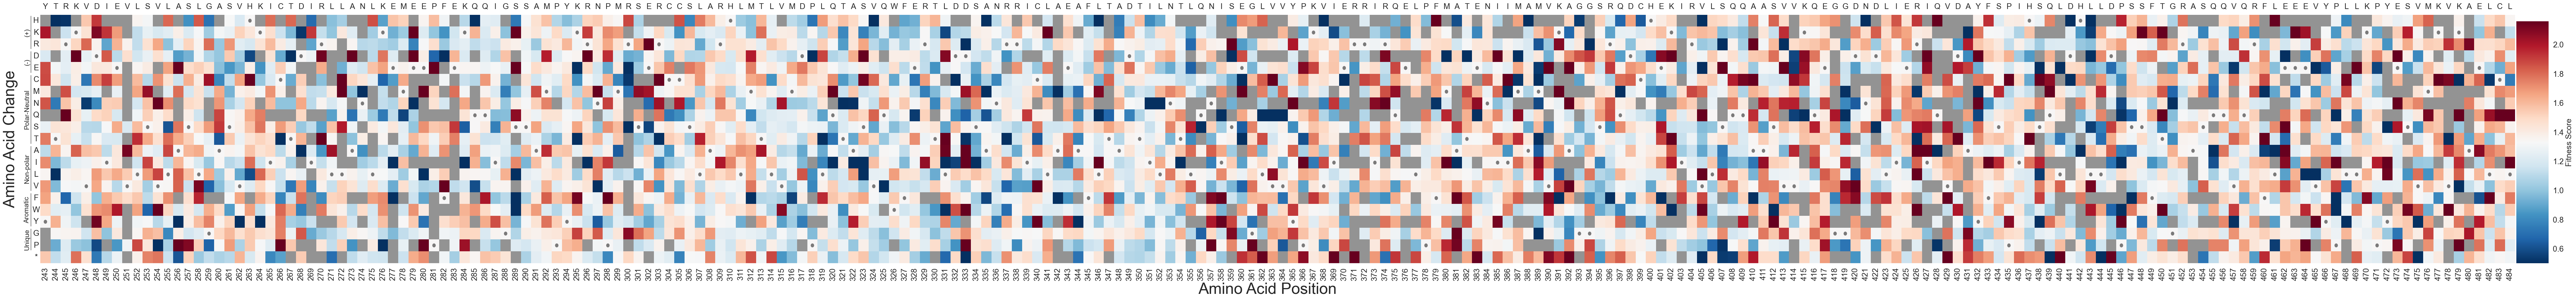

In [149]:
# Call the sfmap_plot function to create a sequence-function map plot and save it to the PDF
sfmap_plot(
    pivot_score[AA_LIST],  # variant effect scores
    "scores",  # label for the data
    amino_seq,  # amino acid sequence used for the plot
    dimensions=[100,10], # dimension [100,10]
    #df_se=pivot_error[AA_LIST],  # Data for standard error (uncertainty)
    show_colorbar=True,  # Show a colorbar on the plot
    show_positions=True,  # Display amino acid positions on the plot
    show_variants=True,  # Display variant information on the plot
    show_wt=True,  # Show the wild-type (reference) sequence on the plot
    aa_list=AA_LIST,  # List of amino acids for the plot
    aa_label_groups=AA_LABEL_GROUPS,  # Grouping of amino acids by properties
    vmax=(wt_score*2)-0.5,
    vmin=0 + 0.5
)

In [16]:
def csv_read_2(experiment, variant_scores = variant_scores):
    df_score = pd.read_csv(f"{variant_scores}\\{experiment}_fitness_score.csv")[["variant", "position", 
                                                                          "fitness_score", "barcodes", "variant_type"]] 
    df_missense = df_score[df_score["variant_type"] == "missense"]
    df_stop_gain = df_score[df_score["variant_type"]=="stop_gain"]
    df_synonymous = df_score[df_score["variant_type"] == "synonymous"]
    df_unmutated = df_score[df_score["variant_type"] == "unmutated"]
    return df_score, df_missense, df_stop_gain, df_synonymous, df_unmutated

In [19]:
def plot_violin(experiment):
    df_score, df_missense, df_stop_gain, df_synonymous, df_unmutated = csv_read_2(experiment)
    sns.set(font_scale = 1.25, font = "arial", rc={'figure.figsize':(4,4)}, style = "ticks")
    sns.violinplot(data = df_score[df_score["variant_type"]!="unmutated"], x = "variant_type", y = "fitness_score", 
                   hue = "variant_type", palette = palette[2:5], order = ["synonymous", "missense", "stop_gain"], cut = 0)
    plt.axhline(y=df_unmutated["fitness_score"].median(), linestyle='--', label = "Wild type", color = "gray")
    plt.axhline(y=df_stop_gain["fitness_score"].median(), linestyle='--', label = "StopGain", color = "black")
    plt.xticks([0,1,2], ["Synonymous","Missense", "StopGain"])
    plt.xlabel("")
    plt.ylabel("Fitness Score$_{XL}$")
    plt.legend(fontsize = 12)
    #plt.ylim(0.75,2)
    #plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
    #plt.close()
    return

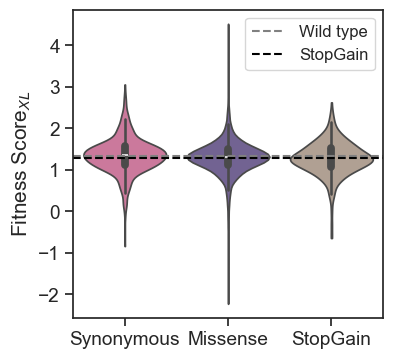

In [23]:
experiment = "lowADSL_dox-"
plot_violin(experiment)

In [24]:
df_score, df_missense, sgain, syn, df_unmutated = csv_read_2(experiment)

In [25]:
from scipy.stats import ttest_ind, mannwhitneyu
# Two-sample t-test (assumes normal distribution)
t_stat, p_val = ttest_ind(syn["fitness_score"], sgain["fitness_score"], equal_var=False)
print("t-test:", t_stat, p_val)

t-test: 2.7996564700031477 0.005220998821649344
